# Poisson Regression

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson as pois
import time
from copy import deepcopy
import pandas as pd
from sklearn.model_selection import train_test_split as split

In [83]:
def f_poisson(T,a,b):
    '''
    T is the weight vector in R^n, a is the regressor matrix in R^{n x m}, b is the count data in R^m
    '''
    u = a @ T
    return np.sum(np.exp(u)) - np.dot(y,u)
def g_poisson(T,a,b):
    '''
    T is the weight vector in R^n, a is the regressor matrix in R^{n x m}, b is the count data in R^m
    '''
    u = np.exp( a @ T )
    return a.T @ u - np.dot(b,a)
def GD_poisson(T,grad,LAMBDA):
    '''Perform Steepest Gradient Descent'''
    return T - LAMBDA*grad
def ren(x): return range(len(x))
rng = np.random.default_rng()

In [84]:
N = 10
M = 20000

In [85]:
omega = rng.random(N +1)
X = rng.random((M,N))
x = np.concatenate((np.ones((M,1)),X),axis = 1)
lamb = np.dot(x , omega)
y = np.array([pois.rvs(i) for i in lamb])
th = rng.random(len(x[0]))

In [86]:
x

array([[1.        , 0.97890189, 0.91557612, ..., 0.59363236, 0.84708593,
        0.06934693],
       [1.        , 0.07245649, 0.19375359, ..., 0.68773938, 0.3137442 ,
        0.61399831],
       [1.        , 0.48635155, 0.56113936, ..., 0.05382064, 0.56466005,
        0.14857876],
       ...,
       [1.        , 0.98495292, 0.13272565, ..., 0.52118821, 0.53764255,
        0.9095518 ],
       [1.        , 0.669651  , 0.3994787 , ..., 0.12854025, 0.05109209,
        0.70942851],
       [1.        , 0.42113678, 0.68433774, ..., 0.99761429, 0.82462771,
        0.38721531]])

In [147]:
np.shape(x.T@x)

(11, 11)

## Vanilla

In [87]:
ERROR = 1e-6

In [89]:
1/np.max( np.linalg.svd( x.T@x )[1] )

1.4026895439364385e-05

In [150]:
initialTime = time.time()
weights = deepcopy(th)
# lam = 1
lam = 1/np.max( np.linalg.svd( x.T @ x )[1] )
lamListVan = []
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
# print(gradNorm)
gradientValueList = [gradNorm]
functionVals = [f_poisson(weights,x,y)]
timeList = [time.time() - initialTime]
while gradNorm > ERROR:
    lamListVan.append(lam)
    weights = GD_poisson(weights,grad,lam)
    grad = g_poisson(weights,x,y)
    gradNorm = np.linalg.norm(grad)
#     print(gradNorm)
    gradientValueList.append(gradNorm)
    functionVals.append(f_poisson(weights,x,y))
    timeList.append(time.time()-initialTime)
    if gradientValueList[-1] >= gradientValueList[-2]:
        print('ping! Iteration:', len(gradientValueList))
        weights = deepcopy(th)
        lam = 0.1*lam
        grad = g_poisson(weights,x,y)
        gradNorm = np.linalg.norm(grad)
        gradientValueList.append(gradNorm)
        functionVals.append(f_poisson(weights,x,y))
        timeList.append(time.time()-initialTime)

ping! Iteration: 4


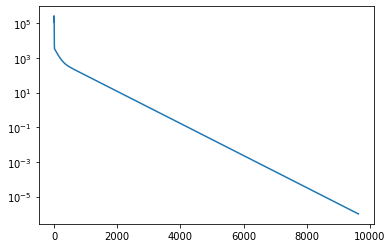

In [119]:
plt.plot(ren(gradientValueList), gradientValueList)
plt.yscale('log')
plt.show()

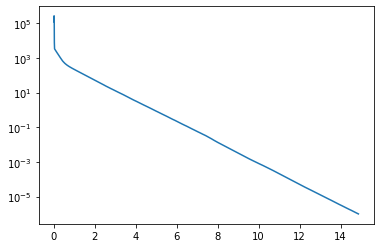

In [120]:
plt.plot(timeList, gradientValueList)
plt.yscale('log')
plt.show()

In [93]:
lam

1.4026895439364386e-06

## Adaptive

In [113]:
initialTime = time.time()
weights = deepcopy(th)
lam = 1/np.max(np.linalg.svd(x.T @ x)[1]*M*N)
lamListAdap = [lam]
theta = np.inf
weights0 = deepcopy(weights)
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
gradientValueList = [gradNorm]
functionVals = [f_poisson(weights,x,y)]
timeList = [time.time() - initialTime]

weights = GD_poisson(weights,grad,lam)
oldGrad = deepcopy(grad)
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
gradientValueList.append(gradNorm)
functionVals.append(f_poisson(weights,x,y))
timeList.append(time.time()-initialTime)
while gradNorm > ERROR:
    lam0 = deepcopy(lam)
    min1 = np.sqrt(1 + theta)*lam
    min2_nom = np.linalg.norm(weights - weights0)
    min2_denom = 2*np.linalg.norm(grad - oldGrad)
    lam = np.min([min1, (min2_nom/min2_denom)])
    lamListAdap.append(lam)
    weights0 = deepcopy(weights)
    weights = GD_poisson(weights,grad,lam)
    theta = lam/lam0
    oldGrad = grad
    grad = g_poisson(weights,x,y)
    gradNorm = np.linalg.norm(grad)
    gradientValueList.append(gradNorm)
    functionVals.append(f_poisson(weights,x,y))
    timeList.append(time.time()-initialTime)

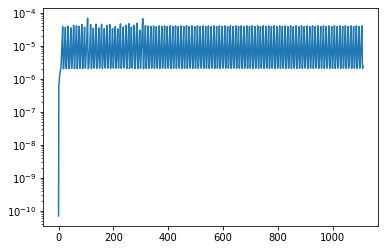

In [114]:
plt.plot(ren(lamListAdap), lamListAdap)
plt.yscale('log')
plt.show()

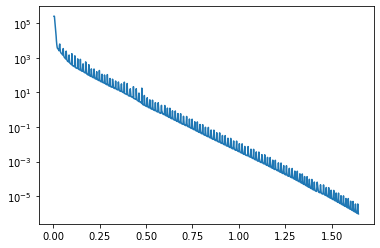

In [100]:
plt.plot(timeList, gradientValueList)
plt.yscale('log')
plt.show()

In [101]:
lam

2.485432468894567e-06

## Gradient-Based Line Search

In [152]:
rho = rng.random()
rng.uniform(rho,10)

5.152580626686573

In [117]:
def BackTrack(GRAD, GRADNORM, W, X,Y):
    rho = rng.random()
    LAM = rng.random()*10
    while 1 > (GRADNORM/np.linalg.norm( g_poisson(W - LAM*GRAD, X, Y) - GRAD ) ):
        LAM = rho*LAM
    return LAM
initialTime = time.time()
weights = deepcopy(th)
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
lam = BackTrack(grad, gradNorm, weights, x, y)
lamListLS = [lam]
gradientValueList = [gradNorm]
functionVals = [f_poisson(weights,x,y)]
timeList = [time.time() - initialTime]
while gradNorm > ERROR:
    weights = GD_poisson(weights,grad,lam)
    grad = g_poisson(weights,x,y)
    gradNorm = np.linalg.norm(grad)
    lam = BackTrack(grad, gradNorm, weights, x, y)
    lamListLS.append(lam)
    gradientValueList.append(gradNorm)
    functionVals.append(f_poisson(weights,x,y))
    timeList.append(time.time()-initialTime)

<ipython-input-83-9594c21dce5e>:11: RuntimeWarning: overflow encountered in exp
  u = np.exp( a @ T )
<ipython-input-83-9594c21dce5e>:12: RuntimeWarning: overflow encountered in matmul
  return a.T @ u - np.dot(b,a)


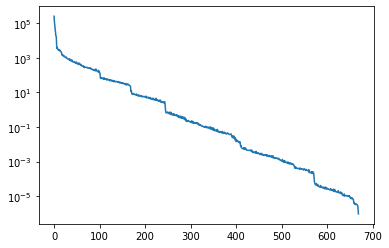

In [103]:
plt.plot(ren(gradientValueList), gradientValueList)
plt.yscale('log')
plt.show()

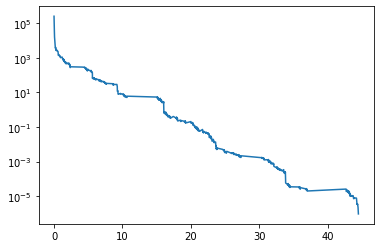

In [104]:
plt.plot(timeList, gradientValueList)
plt.yscale('log')
plt.show()

In [105]:
lam

4.198896582983982e-06

## Barzilai-Borwein

In [111]:
initialTime = time.time()
weights = deepcopy(th)
lam = 1/np.max(np.linalg.svd(x.T @ x)[1]*M*N)
lamList = [lam]
weights0 = deepcopy(weights)
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
gradientValueList = [gradNorm]
functionVals = [f_poisson(weights,x,y)]
timeList = [time.time() - initialTime]

weights = GD_poisson(weights,grad,lam)
oldGrad = deepcopy(grad)
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
gradientValueList.append(gradNorm)
functionVals.append(f_poisson(weights,x,y))
timeList.append(time.time()-initialTime)
while gradNorm > ERROR:
    nom = np.dot(weights - weights0, grad - oldGrad)
    denom = np.linalg.norm(grad - oldGrad)**2
    lam = nom/denom
    lamList.append(lam)
    weights0 = deepcopy(weights)
    weights = GD_poisson(weights,grad,lam)
    oldGrad = deepcopy(grad)
    grad = g_poisson(weights,x,y)
    gradNorm = np.linalg.norm(grad)
    gradientValueList.append(gradNorm)
    functionVals.append(f_poisson(weights,x,y))
    timeList.append(time.time()-initialTime)

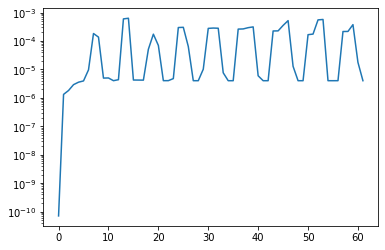

In [112]:
plt.plot(ren(lamList), lamList)
plt.yscale('log')
plt.show()

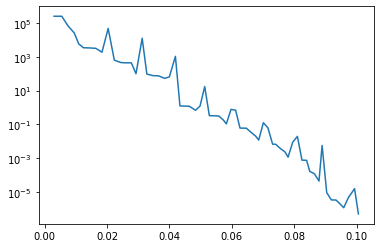

In [108]:
plt.plot(timeList, gradientValueList)
plt.yscale('log')
plt.show()

In [109]:
lam

4.001561948790008e-06

## Nesterov

In [138]:
initialTime = time.time()
weights = deepcopy(th)
L = np.max( np.linalg.svd( x.T @ x )[1] )
# L = 10
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
# print(gradNorm)
gradientValueList = [gradNorm]
functionVals = [f_poisson(weights,x,y)]
timeList = [time.time() - initialTime]
lam1 = 1
y0 = weights
while gradNorm > ERROR:
    lam = 0.5*(1 + np.sqrt(1 + 4*lam1**2))
    gamma = (1 - lam1)/lam
    y1 = weights - grad/L
    weights = (1 - gamma)*y1 + gamma*y0
    lam1 = lam
    y0 = y1
    grad = g_poisson(weights,x,y)
    gradNorm = np.linalg.norm(grad)
#     print(gradNorm)
    gradientValueList.append(gradNorm)
    functionVals.append(f_poisson(weights,x,y))
    timeList.append(time.time()-initialTime)
    if gradientValueList[-1] == gradientValueList[-2]:
        print('ping! Iteration:', len(gradientValueList))
        weights = deepcopy(th)
        L = L*10
        grad = g_poisson(weights,x,y)
        gradNorm = np.linalg.norm(grad)
        gradientValueList.append(gradNorm)
        functionVals.append(f_poisson(weights,x,y))
        timeList.append(time.time()-initialTime)
        lam1 = 1
        y0 = weights

ping! Iteration: 6


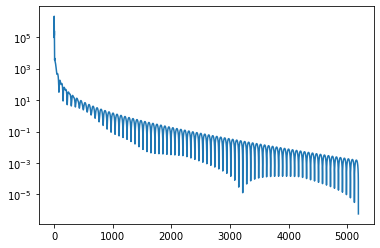

In [134]:
plt.plot(ren(gradientValueList), gradientValueList)
plt.yscale('log')
plt.show()

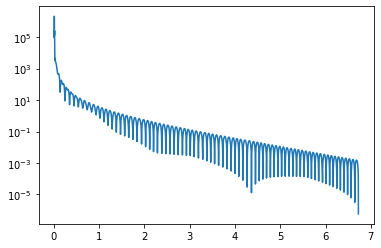

In [135]:
plt.plot(timeList, gradientValueList)
plt.yscale('log')
plt.show()

In [136]:
1/L

1.4026895439364386e-06

Step Size Comparison

In [137]:
gamList

[0.6180339887498948,
 0.7376403052281875,
 0.7977067398993897,
 0.8345650247944008,
 0.8596979789850534,
 0.6180339887498948,
 0.7376403052281875,
 0.7977067398993897,
 0.8345650247944008,
 0.8596979789850534,
 0.8780142692013028,
 0.8919934820287628,
 0.9030323779083411,
 0.9119812486734317,
 0.9193888535624439,
 0.9256259127933997,
 0.9309522636902124,
 0.9355556359124805,
 0.9395751592114159,
 0.9431162051350226,
 0.9462600843658513,
 0.9490705719305759,
 0.9515984114068218,
 0.9538844943822767,
 0.9559621495910932,
 0.9578588203050215,
 0.9595973130104514,
 0.9611967402660464,
 0.9626732418849435,
 0.9640405430804297,
 0.9653103911015549,
 0.9664929002011854,
 0.9675968266729594,
 0.9686297899866749,
 0.9695984519790719,
 0.9705086631141445,
 0.9713655826758444,
 0.9721737781663393,
 0.9729373079964179,
 0.9736597906605788,
 0.9743444629097393,
 0.9749942289136232,
 0.9756117020025351,
 0.9761992402651596,
 0.9767589770337219,
 0.9772928470943808,
 0.9778026093071986,
 0.9782898661

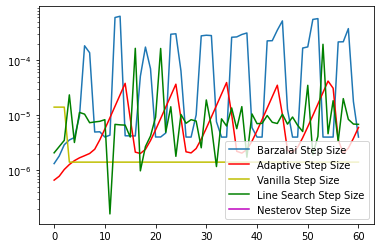

In [127]:
plt.plot(ren(lamList[1:]), lamList[1:], label = 'Barzalai Step Size')
plt.plot(ren(lamList[1:]), lamListAdap[1:len(lamList)], c= 'r', label = 'Adaptive Step Size')
plt.plot(ren(lamList[1:]), lamListVan[1:len(lamList)], c= 'y', label = 'Vanilla Step Size')
plt.plot(ren(lamList[1:]), lamListLS[1:len(lamList)], c= 'g', label = 'Line Search Step Size')
plt.plot(ren(lamList[1:]), gamList[1:len(lamList)], c= 'm', label = 'Nesterov Step Size')
plt.yscale('log')
plt.legend(loc = 'lower right')
plt.show()

In [141]:
import plotly.express as px

In [145]:
Steps = pd.DataFrame(dict(
    baz = lamList,
    adap = lamListAdap,
    ls = lamListLS,
    van = lamListVan
))

ValueError: arrays must all be same length

In [144]:
fig = px.line(pd.DataFrame({'x' :ren(lamList),'y':lamList}), x='x', y='y', log_y = True)
fig.show()